In this project I worked with a challenging time-series dataset consisting of daily sales data provided by one of the largest Russian software firms - 1C Company. 

Goal : To predict total sales for every product and store in the next month.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
dataset = pd.read_csv("/content/drive/My Drive/sales_train.csv")
dataset.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')

In [ ]:
test = pd.read_csv('test.csv')
print(test.head())

   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268


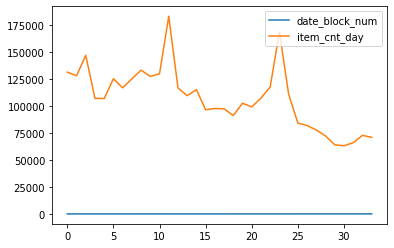

In [ ]:
dfm = dataset.groupby(['date_block_num'], as_index=False )['item_cnt_day'].sum()
dfm.head()
dfm.plot()

We can see that as the time progresses the item count drops.

Removing the outliers

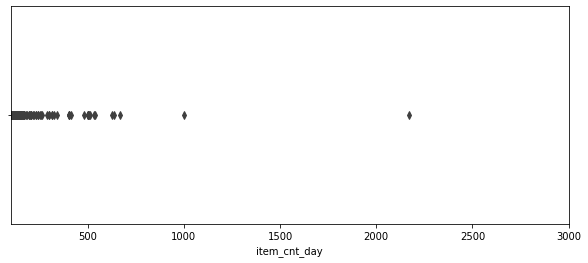

In [ ]:
plt.figure(figsize=(10,4))
plt.xlim(100, 3000)
sns.boxplot(x=dataset.item_cnt_day)

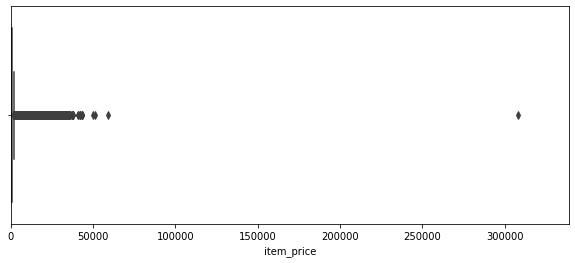

In [ ]:
plt.figure(figsize=(10,4))
plt.xlim(dataset.item_price.min(), dataset.item_price.max()*1.1)
sns.boxplot(x=dataset.item_price)

In [ ]:
dataset = dataset[dataset.item_price<100000]
dataset = dataset[dataset.item_cnt_day<1001]

In [ ]:
median = dataset[(dataset.shop_id==32)&(dataset.item_id==2973)&(dataset.date_block_num==4)&(dataset.item_price>0)].item_price.median()
dataset.loc[dataset.item_price<0, 'item_price'] = median
dataset.loc[dataset.item_cnt_day<0, 'item_cnt_day'] = 1

In [ ]:
from itertools import product
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(0,34):
  month = dataset[dataset.date_block_num == i]
  matrix.append(np.array(list(product([i], month.shop_id.unique(), month.item_id.unique())), dtype='int16'))

matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
matrix.head()

,date_block_num,shop_id,item_id
139255,0,0,19
141495,0,0,27
144968,0,0,28
142661,0,0,29
138947,0,0,32


In [ ]:
dataset['revenue'] = dataset['item_price'] * dataset['item_cnt_day']

In [ ]:
dataset.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,1.0,899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00


Add the item count per month feature

In [ ]:
group = dataset.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)
print(group)
matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20)
                                .astype(np.float16))

         date_block_num  shop_id  item_id  item_cnt_month
0                     0        0       32             6.0
1                     0        0       33             3.0
2                     0        0       35             1.0
3                     0        0       43             1.0
4                     0        0       51             2.0
...                 ...      ...      ...             ...
1609118              33       59    22087             6.0
1609119              33       59    22088             2.0
1609120              33       59    22091             1.0
1609121              33       59    22100             1.0
1609122              33       59    22102             1.0

[1609123 rows x 4 columns]


In [ ]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0
3,0,0,29,0.0
4,0,0,32,6.0


Append test pairs to the matrix

In [ ]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
print(test.head())

   ID  shop_id  item_id  date_block_num
0   0        5     5037              34
1   1        5     5320              34
2   2        5     5233              34
3   3        5     5232              34
4   4        5     5268              34


In [ ]:
matrix = pd.concat([matrix , test], keys=cols, ignore_index=True, sort=False)
matrix.fillna(0, inplace=True)

In [ ]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID
0,0,0,19,0.0,0.0
1,0,0,27,0.0,0.0
2,0,0,28,0.0,0.0
3,0,0,29,0.0,0.0
4,0,0,32,6.0,0.0


Add lag features

In [ ]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df


In [ ]:
matrix = lag_feature(matrix, [1,2,3], 'item_cnt_month')

In [ ]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,0,0,19,0.0,0.0,NaN,NaN,NaN
1,0,0,27,0.0,0.0,NaN,NaN,NaN
2,0,0,28,0.0,0.0,NaN,NaN,NaN
3,0,0,29,0.0,0.0,NaN,NaN,NaN
4,0,0,32,6.0,0.0,NaN,NaN,NaN


Add average item cnt for each month

In [ ]:
group = matrix.groupby('date_block_num').agg({'item_cnt_month' : ['mean']})
group.columns = ['date_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on='date_block_num', how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], 'date_avg_item_cnt')
matrix.drop('date_avg_item_cnt', inplace=True, axis=1)

Add the average item count for each item in a month

In [ ]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month' : ['mean']})
group.columns = ['date_item_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], 'date_item_avg_item_cnt')
matrix.drop('date_item_avg_item_cnt', inplace=True, axis=1) 

Add the average item count for each shop in a month

In [ ]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month' : ['mean']})
group.columns = ['date_shop_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], 'date_shop_avg_item_cnt')
matrix.drop('date_shop_avg_item_cnt', inplace=True, axis=1) 

Add the price and revenue for each item

In [ ]:
group = dataset[['date_block_num', 'shop_id', 'item_id', 'item_price', 'revenue']]
matrix = pd.merge(matrix, group, how='left', on=cols)
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'date_avg_item_cnt_lag_1', 'date_avg_item_cnt_lag_2',
       'date_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'item_price', 'revenue'],
      dtype='object')

Add month, date features

In [ ]:
matrix['month'] = matrix['date_block_num'] % 12

In [ ]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [ ]:
matrix = matrix[matrix.date_block_num > 11]

Fill all the null values

In [ ]:
matrix.fillna(0, inplace=True)

In [ ]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7386180 entries, 5068548 to 12454727
Data columns (total 21 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   date_block_num                int8   
 1   shop_id                       int8   
 2   item_id                       int16  
 3   item_cnt_month                float16
 4   ID                            float64
 5   item_cnt_month_lag_1          float16
 6   item_cnt_month_lag_2          float16
 7   item_cnt_month_lag_3          float16
 8   date_avg_item_cnt_lag_1       float16
 9   date_avg_item_cnt_lag_2       float16
 10  date_avg_item_cnt_lag_3       float16
 11  date_item_avg_item_cnt_lag_1  float16
 12  date_item_avg_item_cnt_lag_2  float16
 13  date_item_avg_item_cnt_lag_3  float16
 14  date_shop_avg_item_cnt_lag_1  float16
 15  date_shop_avg_item_cnt_lag_2  float16
 16  date_shop_avg_item_cnt_lag_3  float16
 17  item_price                    float64
 18  revenue        

Split the data into training, val and test set

In [ ]:
X_train = matrix[matrix['date_block_num'] < 33].drop('item_cnt_month', axis=1)
Y_train = matrix[matrix['date_block_num'] < 33]['item_cnt_month']
X_valid = matrix[matrix.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = matrix[matrix.date_block_num == 33]['item_cnt_month']
X_test = matrix[matrix.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (6186922, 18, 1)
Validation set shape (238172, 18, 1)


Building your LSTM model

In [ ]:
from tensorflow.keras.optimizers import Adam
epochs = 40
batch = 256
lr = 0.0003
adam = Adam(lr)

In [ ]:
from tensorflow import keras
from keras.models import Sequential

model_lstm = Sequential()
model_lstm.add(keras.layers.LSTM(24, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(keras.layers.Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24)                2496      
_________________________________________________________________
dense (Dense)                (None, 1)                 25        
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=10, verbose=2)

In [ ]:
from xgboost import XGBRegressor
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

In [ ]:
model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=2, 
    early_stopping_rounds = 10)

[08:33:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:20] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [ ]:
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))

In [ ]:
Y_pred = model_lstm.predict(X_valid_series).clip(0, 20)
Y_test = model_lstm.predict(X_test_series).clip(0, 20)

from sklearn.metrics import r2_score
print(r2_score(Y_valid, Y_pred))

0.28698434292952646


In [ ]:
print(Y_test.shape)

(214200, 1)


In [ ]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test.flatten()
})
submission.to_csv('xgb_submission.csv', index=False)

In [ ]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)